In [1]:
# importing every necessary function and library
from sklearn.datasets import load_iris
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier ,export_graphviz
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  ## maybe use something different that accuracy later on
from sklearn.model_selection import ShuffleSplit
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("../task_data.csv")


In [3]:
data = data.replace(',', '.', regex=True)

In [4]:
data.isnull().values.any()

np.False_

In [5]:
data.head(37)
X = data.drop(columns=['ID', 'Cardiomegaly']) ## dropping ID, because there is no use for it (especially in a decision tree)
y = data['Cardiomegaly']                      ## however Cardiomegaly has a use in determining the result
## print(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) ## random state, so best_params_ stay the same throughout the whole process

print("data shape:", data.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X cols:", list(X.columns))

data shape: (37, 14)
X shape: (37, 12)
y shape: (37,)
X cols: ['Heart width', 'Lung width', 'CTR - Cardiothoracic Ratio', 'xx', 'yy', 'xy', 'normalized_diff', 'Inscribed circle radius', 'Polygon Area Ratio', 'Heart perimeter', 'Heart area ', 'Lung area']


In [6]:
params = {'max_depth': [None, 2, 3, 4, 5], 'max_leaf_nodes': [None, 2, 4, 8, 16, 32]} 
clf = GridSearchCV(DecisionTreeClassifier(), params)  # I prefer this over finding the parameters manually

In [7]:
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 2, 'max_leaf_nodes': 8}

In [8]:
accuracy = clf.score(X_test, y_test) # yes, metrics will appear later on
print("Accuracy: ", accuracy)

Accuracy:  0.8333333333333334


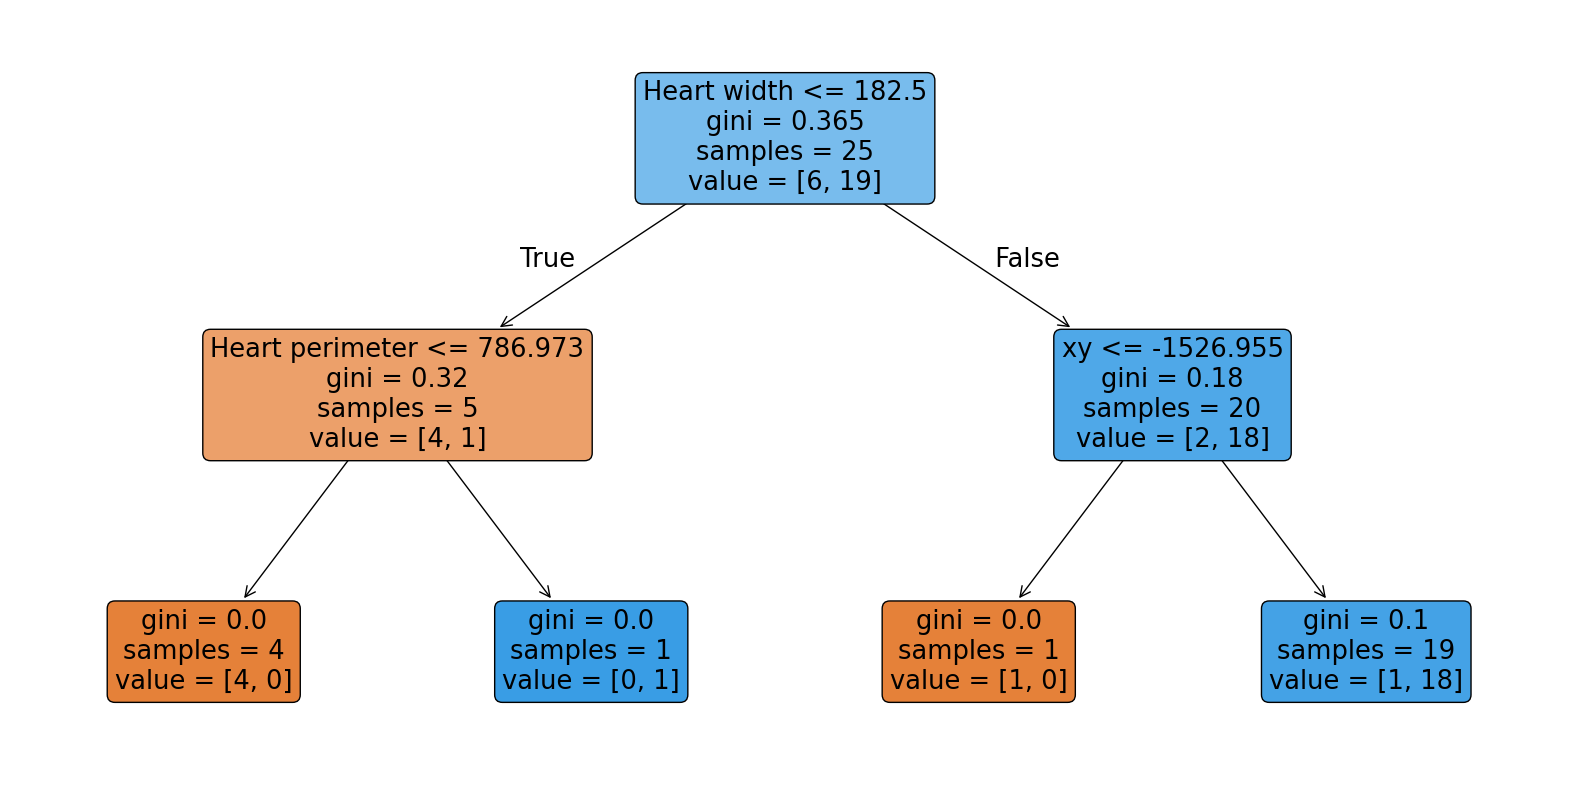

In [9]:
best_tree = clf.best_estimator_
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X.columns, filled=True, rounded=True)
plt.show()

#### The test above has shown that the model predicts results within ~75-91.66% accuracy (with really specific numbers, e.g. 75%, 81.3333%). This only shows that since the dataset is relatively small, values will be repetitive. *

#### * that's my 2nd most frequent result - sometimes the tree has only 2 leaves and then the accuracy drops by 5-15% **

In [ ]:
# also checking manually to see where it fails
from sklearn.metrics import precision_score, f1_score, recall_score
y_pred = best_tree.predict(X_test)
    
print("Predicted values: ", y_pred[:20])
print("Actual values: ", list(y_test[:20]))

Predicted values:  [1 0 1 1 1 1 1 1 1 1 0 1]
Actual values:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]


### Testing results for all necessary metrics

In [ ]:
# playing with statistics
y_true = y_test

# ** the statistics in the comments apply to my previous run 

# recall                                        88.88%
rc = recall_score(y_true, y_pred)
print("Recall: ", rc)

# accuracy                                      75%
acc = accuracy_score(y_true, y_pred)
print("Accuracy: ", acc)

# f1                                            84%
f1 = f1_score(y_true, y_pred)
print("F1-score: ", f1)

# precision                                     80%
prec = precision_score(y_true, y_pred)
print("Precision: ", prec)

# confusion matrix                              75%
conf_matrix = confusion_matrix(y_true, y_pred)  ##  TN, FP
print("Confusion Matrix: \n", conf_matrix)                              ##  FN, TP

Recall:  1.0
Accuracy:  0.9166666666666666
F1-score:  0.9473684210526315
Precision:  0.9
Confusion Matrix: 
 [[2 1]
 [0 9]]


### Visualizing metrics values depending on the test size

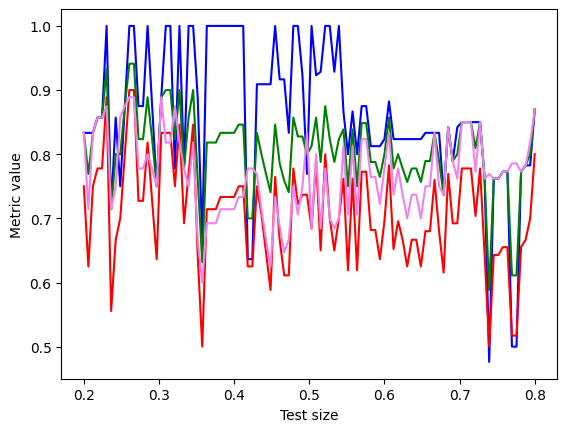

In [ ]:
from sklearn.model_selection import StratifiedKFold

test_sizes = np.linspace(0.2, 0.8, 100)

y_recall, y_accuracy, y_f1, y_precision = [], [], [], []

for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
    params = {'max_depth': [None, 2, 3, 4, 5], 'max_leaf_nodes': [None, 2, 4, 8, 16, 32]} 

    # to make a fixed number of splits and to prevent warnings
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    clf = GridSearchCV(DecisionTreeClassifier(), params, cv=cv) 
    
    clf.fit(X_train, y_train)

    best_tree = clf.best_estimator_
    
    y_pred = best_tree.predict(X_test)

    y_pred = clf.best_estimator_.predict(X_test)
    y_true = y_test


    # recall                                        88.88%
    rc = recall_score(y_true, y_pred)
    y_recall.append(rc)
    #print("Recall: ", rc)

    # accuracy                                      75%
    acc = accuracy_score(y_true, y_pred)
    y_accuracy.append(acc)
    #print("Accuracy: ", acc)

    # f1                                            84%
    f1 = f1_score(y_true, y_pred)
    y_f1.append(f1)
    #print("F1-score: ", f1)

    # precision                                     80%
    prec = precision_score(y_true, y_pred)
    y_precision.append(prec)
    #print("Precision: ", prec)

    # confusion matrix                              75%
    conf_matrix = confusion_matrix(y_true, y_pred)  ##  TN, FP
    #print("Confusion Matrix: \n", conf_matrix)

plt.plot(test_sizes, y_recall, color='blue', label='Recall')
plt.plot(test_sizes, y_accuracy, color='red', label='Accuracy')
plt.plot(test_sizes, y_f1, color='green', label='f1-score')
plt.plot(test_sizes, y_precision, color='violet', label='precision')

plt.xlabel("Test size")
plt.ylabel("Metric value")

plt.show()

#### Generally random values, but when the test size is bigger than 55%, the highest overall metric (precision) doesn't ever reach 90%


### Receiver Operating Characteristic + Precision-Recall curves

In [ ]:
from sklearn.metrics import roc_curve, auc, PrecisionRecallDisplay

FPR: [0.         0.42857143 1.        ]
TPR: [0.         0.86956522 1.        ]
Thresholds: [inf  1.  0.]
AUC = 0.720


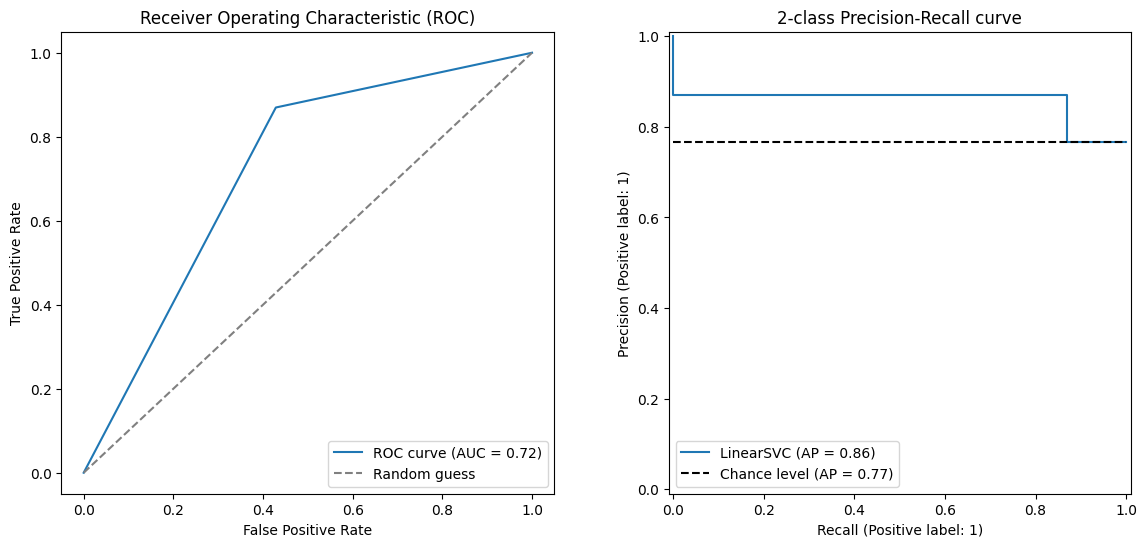

In [ ]:
y_score = best_tree.predict_proba(X_test)[:, 1]

# ROC setup
fpr, tpr, thresholds = roc_curve(y_test, y_score) ## FPR = FP/(FP + TN) => precision | TPR = TP/(TP + FN) => sensitivity (recall)
roc_auc = auc(fpr, tpr)                           ## x values -> FPR | y values -> TPR       

print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresholds)
print(f"AUC = {roc_auc:.3f}")
## the bigger the are under the ROC curve, the more accurately the model predicts correct values

# plot ROC curve

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC)')
axs[0].legend(loc='lower right')

# plot PR curve

display = PrecisionRecallDisplay.from_estimator(
    best_tree, X_test, y_test, name="LinearSVC", plot_chance_level=True, ax=axs[1]
)
axs[1].set_title("2-class Precision-Recall curve") 


plt.show()

Since there are two possible outcomes (0 and 1), the ROC curve will not give us a high AUC value (having computed the code before a few times, AUC varies between 0.53, 0.6, 0.72 values).

The model doesn't generalize perfectly, but considering that the dataset is a bit small, the results are reasonable.